In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.io.wavfile import write
from pydub import AudioSegment

c:\Users\Muhammad Zaky T A\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def audio_proses(nama_file):
    audio = AudioSegment.from_wav(nama_file)
    sampel= np.array(audio.get_array_of_samples(), dtype=np.float32)
    sampel /= np.max(np.abs(sampel))  # Normalisasi ke -1 hingga 1
    return sampel, audio.frame_rate

# Fungsi untuk menyimpan audio
def save_audio(nama_file, sampel, frame_rate):
    scaled_samples = np.int16(sampel / np.max(np.abs(sampel)) * 32767)  # Normalisasi ke 16-bit
    write(nama_file, frame_rate, scaled_samples)

# Muat kedua file audio
noisy_signal, fs_noisy = audio_proses('audio1.wav')
clean_signal, fs_clean = audio_proses('sp01.wav')

# Pastikan sample rate kedua file sama
assert fs_noisy == fs_clean

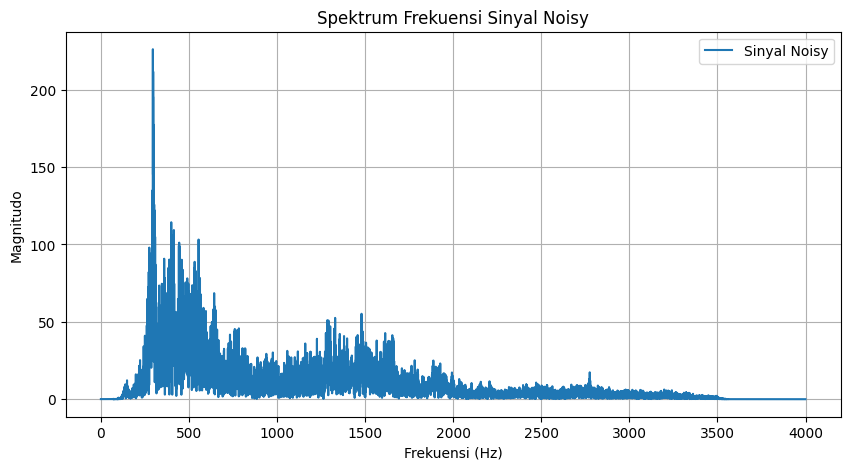

level kebisingan = 9.940958


In [4]:
def analyze_spectrum(signal, fs, title):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / fs)
    return xf[:N // 2], np.abs(yf[:N // 2])  # Positive frequencies

noisy_freq, noisy_magnitude = analyze_spectrum(noisy_signal, fs_noisy, "Spektrum Sinyal Noise")

# Plot spectrum
plt.figure(figsize=(10, 5))
plt.plot(noisy_freq, noisy_magnitude, label="Sinyal Noisy")
plt.title("Spektrum Frekuensi Sinyal Noisy")
plt.xlabel("Frekuensi (Hz)")
plt.ylabel("Magnitudo")
plt.grid()
plt.legend()
plt.show()

# Return basic stats for adjustment
noise_level = np.mean(noisy_magnitude)
print("level kebisingan =", noise_level)

In [5]:
def penyesuaian_parameter(spektrum, fs):
    # Dapatkan frekuensi dominan dan tingkat noise
    frekuensi_dominan = np.argsort(spektrum)[-10:]
    rata_level= np.mean(spektrum)
    
    if rata_level> 0.1:
        mu = 0.1  # Step size besar untuk noise tinggi
        n_taps = 128  # Filter panjang untuk noise kompleks
    else:
        mu = 0.05  # Step size kecil untuk noise rendah
        n_taps = 64  # Filter pendek untuk noise lebih stabil

    return mu, n_taps, frekuensi_dominan

# Analisis spektrum sinyal noisy
spektrum = np.abs(fft(noisy_signal))

# Sesuaikan parameter filter berdasarkan spektrum noise
mu, n_taps, frekuensi_dominan = penyesuaian_parameter(spektrum, fs_noisy)

In [6]:
def nlms_filter(noisy_signal, clean_signal, mu=0.05, n_taps=64):
    n_sempel = len(noisy_signal)
    w = np.zeros(n_taps)  # Koefisien filter
    y = np.zeros(n_sempel)  # Output filter
    e = np.zeros(n_sempel)  # Error signal

    for n in range(n_taps, n_sempel):
        x_n = noisy_signal[n-n_taps:n]  # Masukan filter
        energy = np.dot(x_n, x_n)  # Energi input sinyal
        if energy > 0:  # Hindari pembagian dengan nol
            mu_eff = mu / energy  # Sesuaikan step size dengan energi input
        else:
            mu_eff = mu

        y[n] = np.dot(w, x_n)  # Output filter
        e[n] = clean_signal[n] - y[n]  # Error antara sinyal bersih dan output filter
        w += 2 * mu_eff * e[n] * x_n  # Pembaruan koefisien filter

    return y, e

# Terapkan filter NLMS dengan parameter yang disesuaikan
nlms_output, nlms_error = nlms_filter(noisy_signal, clean_signal, mu=mu, n_taps=n_taps)


In [15]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data)

# Terapkan filter spektral setelah NLMS
lowcut = 300  # Frekuensi minimum yang diizinkan (contoh: 300 Hz)
highcut = 3400  # Frekuensi maksimum yang diizinkan (contoh: 3.4 kHz)
filtered_signal = bandpass_filter(nlms_output, lowcut, highcut, fs_noisy)


In [21]:
# Fungsi untuk menghitung MSE (Mean Squared Error)
def menghitung_MSE(clean_signal, filtered_signal):
    return np.mean((clean_signal - filtered_signal) ** 2)

# Fungsi untuk menghitung SNR (Signal-to-Noise Ratio)
def Menghitung_SNR(clean_signal, filtered_signal):
    noise = clean_signal - filtered_signal
    signal_power = np.sum(clean_signal ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [22]:
# Hitung MSE dan SNR untuk sinyal noisy
mse_noisy = menghitung_MSE(clean_signal, noisy_signal)
snr_noisy = Menghitung_SNR(clean_signal, noisy_signal)

print(f"Noisy Signal MSE: {mse_noisy:.6f}")
print(f"Noisy Signal SNR: {snr_noisy:.2f} dB")

# Hitung MSE dan SNR setelah filter NLMS
mse_nlms = menghitung_MSE(clean_signal, nlms_output)
snr_nlms = Menghitung_SNR(clean_signal, nlms_output)

print(f"Filter NLMS MSE: {mse_nlms:.6f}")
print(f"Filter NLMS SNR: {snr_nlms:.2f} dB")

Noisy Signal MSE: 0.003802
Noisy Signal SNR: 4.32 dB
Filter NLMS MSE: 0.001567
Filter NLMS SNR: 8.17 dB


In [18]:
print(f"Panjang sinyal noise: {len(noisy_signal)}")
print(f"Panjang filter NLMS: {len(filtered_signal)}")

Panjang sinyal noise: 22529
Panjang filter NLMS: 22529


In [19]:
from IPython.display import Audio

# Fungsi untuk memutar audio
def play_audio(samples, frame_rate):
    return Audio(data=samples, rate=frame_rate)


In [20]:
# Mainkan audio asli (noisy signal)
print("Audio Noisy:")
display(play_audio(noisy_signal, fs_noisy))

# Mainkan audio setelah filter NLMS
print("Audio Filter NLMS:")
display(play_audio(nlms_output, fs_noisy))

Audio Noisy:


Audio Filter NLMS:


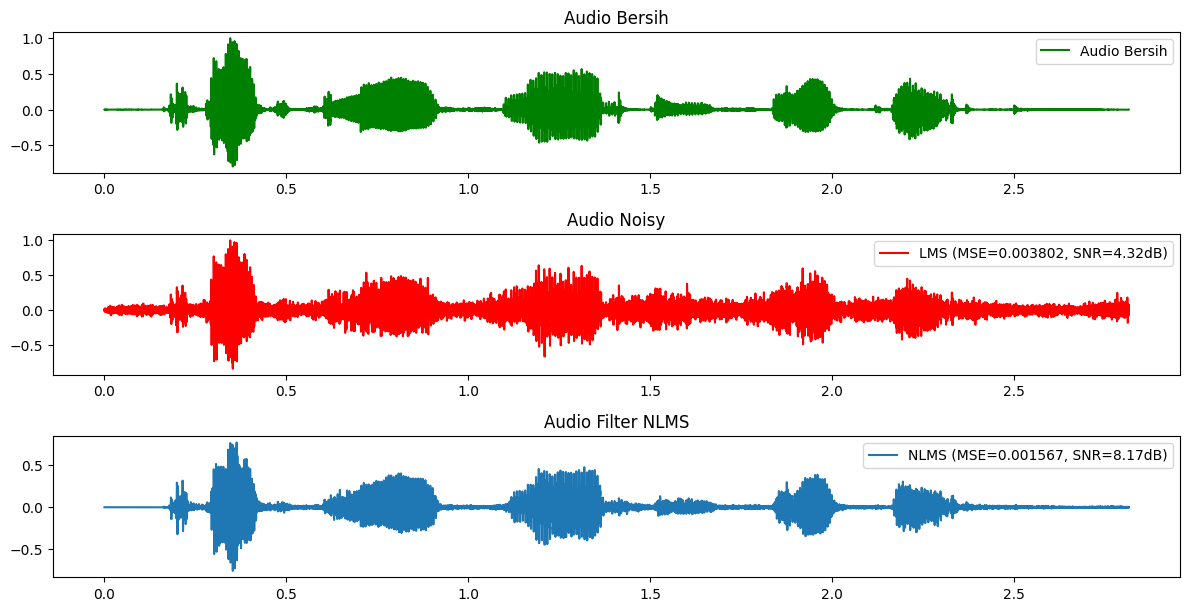

In [20]:
# Plot perbandingan hasil filtering
plt.figure(figsize=(12, 8))
t = np.linspace(0, len(clean_signal)/fs_clean, len(clean_signal))

plt.subplot(4,1,1)
plt.plot(t, clean_signal, label='Audio Bersih', color="green")
plt.title('Audio Bersih')
plt.legend()

plt.subplot(4,1,2)
plt.plot(t, noisy_signal, label=f'LMS (MSE={mse_noisy:.6f}, SNR={snr_noisy:.2f}dB)', color="red")
plt.title('Audio Noisy')
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, nlms_output, label=f'NLMS (MSE={mse_nlms:.6f}, SNR={snr_nlms:.2f}dB)')
plt.title('Audio Filter NLMS')
plt.legend()

plt.tight_layout()
plt.show()

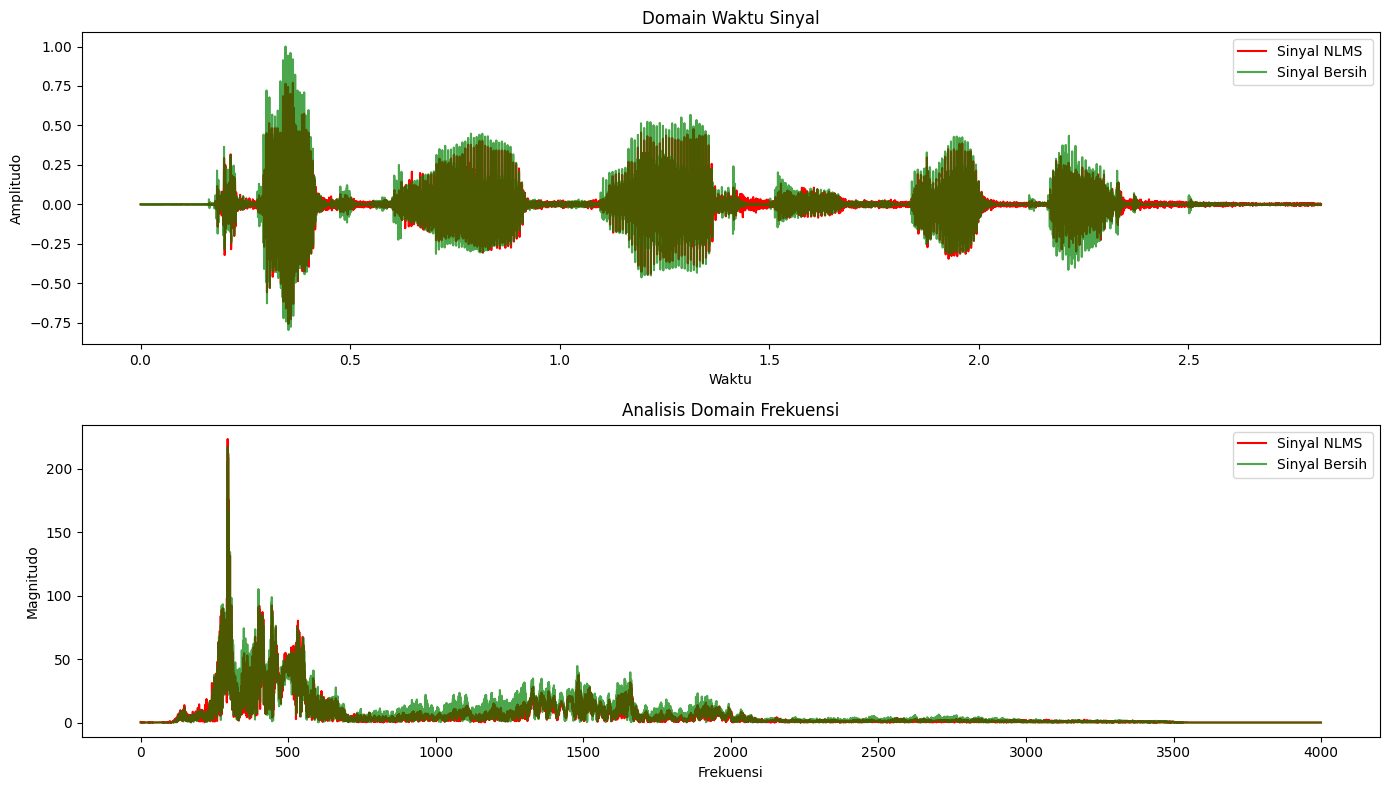

In [21]:
from scipy.fft import fft, fftfreq

# Compute FFT for frequency domain analysis
def compute_fft(signal, fs):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / fs)
    return xf[:N // 2], np.abs(yf[:N // 2])  # Return positive frequencies

nlms_freq, nlms_magnitudo = compute_fft(nlms_output, fs_noisy)
clean_freq, clean_magnitudo = compute_fft(clean_signal, fs_clean)

# Plot time-domain signals
plt.figure(figsize=(14, 8))
time = np.linspace(0, len(nlms_output) / fs_noisy, len(nlms_output))

# Time-domain signals
plt.subplot(2, 1, 1)
plt.plot(time, nlms_output, label="Sinyal NLMS", color="red")
plt.plot(time, clean_signal, label="Sinyal Bersih", color="green", alpha=0.7)
plt.title("Domain Waktu Sinyal")
plt.xlabel("Waktu")
plt.ylabel("Amplitudo")
plt.legend()

# Frequency-domain signals
plt.subplot(2, 1, 2)
plt.plot(nlms_freq, nlms_magnitudo, label="Sinyal NLMS", color="red")
plt.plot(clean_freq, clean_magnitudo, label="Sinyal Bersih", color="green", alpha=0.7)
plt.title("Analisis Domain Frekuensi")
plt.xlabel("Frekuensi")
plt.ylabel("Magnitudo")
plt.legend()

plt.tight_layout()
plt.show()
